In [146]:
#pip install xgboost
#pip install fbprophet

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
#import excel file

import pandas as pd

sku_df = pd.read_excel('/Users/revatirameshkharate/Desktop/ITP Projects/Diggs BI/Diggs SKU Mapping.xlsx', sheet_name='Sheet1')

sku_df=sku_df.drop(['Is Bundle?','Component 1','Component 2','Component 3','Component 4'], axis = 1)
sku_df.rename(columns = {'Diggs SKU':'code'}, inplace = True)

sku_df.head(2)

,code,Product Title,Variant,Category,Color,Size,Prod_variant
0,WSC007AALW,Collar,Collar - Large - Ash,Walk,Ash,Large,Collar- Ash-Large
1,WSC012AALP,Collar,Collar - Large - Blush,Walk,Blush,Large,Collar- Blush-Large


In [5]:
#sku_df.columns.isna()

In [6]:
#importing Inventory products data 

import requests

import json

url = "https://api.cin7.com/api/v1/Products"
query_params = {
    "rows": 250,
    #"where": "createdDate<2023-03-05T00:00:00Z and createdDate>2022-12-31T23:59:59Z",
    #"where": "createdDate BETWEEN '2022-12-31T23:59:59Z' AND '2023-03-01T00:00:00Z'",
    "fields": "productOptions"
    #"fields": "StyleCode, productOptions"
}

headers = {
    "Content-Type": "application/json"
}

auth = ("DiggsIncUS", "9901f725991a42c4b8ea12917e3c21d9")  # replace with your Cin7 username and password

data = []
page = 1
while True:
    query_params["page"] = page
    response = requests.get(url, headers=headers, params=query_params, auth=auth)
    if response.status_code == 200:
        
        # Append the data from the current page to the list of data
        data += response.json()
        # Check if there are more pages of data to fetch
        if len(response.json()) < 250:
            break
        else:
            page += 1
    else:
        print(f"Request failed with status code {response.status_code}")
        break

df = pd.json_normalize(data)

df.head()

,productOptions
0,"[{'id': 968, 'createdDate': '2023-03-16T14:25:..."
1,"[{'id': 967, 'createdDate': '2023-02-23T17:06:..."
2,"[{'id': 966, 'createdDate': '2023-02-23T17:05:..."
3,"[{'id': 965, 'createdDate': '2023-02-23T17:03:..."
4,"[{'id': 964, 'createdDate': '2023-02-23T17:02:..."


In [7]:
df = df.explode('productOptions')

# Use json_normalize to flatten the 'lineItems' column
df_product_options = pd.json_normalize(df['productOptions'])

# Apply function to rename columns
df_product_options = df_product_options.rename(columns=lambda x: x.split(".")[-1])

df.head(4)

,productOptions
0,"{'id': 968, 'createdDate': '2023-03-16T14:25:3..."
1,"{'id': 967, 'createdDate': '2023-02-23T17:06:3..."
2,"{'id': 966, 'createdDate': '2023-02-23T17:05:2..."
3,"{'id': 965, 'createdDate': '2023-02-23T17:03:5..."


In [18]:
df = df.reset_index(drop=True)
# Combine the flattened 'productOptions' DataFrame with the original DataFrame
df_data = pd.concat([df, df_product_options], axis=1)


# Drop the original 'lineItems' column
df_data = df_data.drop('productOptions', axis=1)
df_data.head(2).sort_values(by=['createdDate'])

,id,createdDate,modifiedDate,status,productId,code,barcode,productOptionCode,productOptionSizeCode,productOptionBarcode,...,specialsStartDate,specialDays,stockAvailable,stockOnHand,image,retailUSD,vipusd,wholesaleUSD,costUSD,specialPrice
1,967,2023-02-23T17:06:32Z,2023-02-23T17:06:32Z,Active,1006,MCP001A42G,,MCP001A42G,None,,...,None,0,0.0,0.0,None,0.0,0.0,0.0,16.30,0.0
0,968,2023-03-16T14:25:37Z,2023-03-16T14:31:18Z,Active,1007,AC0X5000V01X,,AC0X5000V01X,None,,...,None,0,0.0,0.0,None,0.0,0.0,0.0,1.37,0.0


In [19]:
df_data.dtypes

df_data = df_data.drop(['modifiedDate', 'productOptionCode', 'productOptionSizeCode',
       'productOptionBarcode', 'barcode', 'supplierCode', 'productOptionSizeBarcode','optionWeight', 'size', 
        'retailPrice',
       'wholesalePrice', 'vipPrice', 'specialPrice', 'specialsStartDate',
       'specialDays',  'image', 'retailUSD',
       'vipusd', 'wholesaleUSD', 'costUSD', 'specialPrice'], axis=1)

df_data.head(3)

,id,createdDate,status,productId,code,option1,option2,option3,stockAvailable,stockOnHand
0,968,2023-03-16T14:25:37Z,Active,1007,AC0X5000V01X,,,,0.0,0.0
1,967,2023-02-23T17:06:32Z,Active,1006,MCP001A42G,grey,XL,,0.0,0.0
2,966,2023-02-23T17:05:23Z,Active,1005,MCP001A40G,grey,Lg,,0.0,0.0


Now we have to dataframes:
                Inventory-df_data 
                SKU mapping - sku_mapping_df

In [20]:
stock_data = pd.merge(df_data, sku_df, on='code')
stock_data.head(3)
#stock_data.dtypes

,id,createdDate,status,productId,code,option1,option2,option3,stockAvailable,stockOnHand,Product Title,Variant,Category,Color,Size,Prod_variant
0,940,2022-11-14T22:04:31Z,Active,979,TPD001AOSC,,,,0.0,0.0,Passenger,Passenger/Pee Pad Bundle - Charcoal,Travel,Charcoal,NaN,Passenger- Charcoal-
1,939,2022-11-14T21:59:15Z,Active,978,WBD001AA4I,,,,0.0,0.0,Poop Bags,Poop Bags 4x Bundle,Walk,NaN,NaN,Poop Bags--
2,938,2022-11-14T21:58:57Z,Active,977,WBD001AA2I,,,,0.0,0.0,Poop Bags,Poop Bags 2x Bundle,Walk,NaN,NaN,Poop Bags--


In [21]:
stock_data1 = stock_data.drop('createdDate', axis = 1)
stock_data1.head(2)

,id,status,productId,code,option1,option2,option3,stockAvailable,stockOnHand,Product Title,Variant,Category,Color,Size,Prod_variant
0,940,Active,979,TPD001AOSC,,,,0.0,0.0,Passenger,Passenger/Pee Pad Bundle - Charcoal,Travel,Charcoal,NaN,Passenger- Charcoal-
1,939,Active,978,WBD001AA4I,,,,0.0,0.0,Poop Bags,Poop Bags 4x Bundle,Walk,NaN,NaN,Poop Bags--


In [22]:
### March 18th

In [23]:
## Avilability by Prod Title

# group by products sold high level view

summarized_df = pd.DataFrame(stock_data1.groupby(['Product Title']).agg({'stockAvailable': 'sum'}).reset_index())

summarized_df = summarized_df.sort_values(by='stockAvailable', ascending=False)

summarized_df.head()

,Product Title,stockAvailable
5,Groov,45827.0
3,Collar,21707.0
7,Leash,20952.0
13,Revol,20517.0
4,Dispenser,14393.0


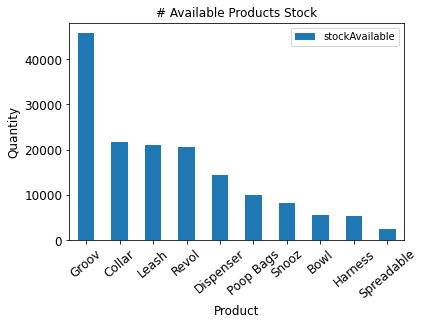

In [24]:
import matplotlib.pyplot as plt

fig1 = summarized_df.head(10).plot(kind = 'bar', x= 'Product Title' , y ='stockAvailable', title ="# Available Products Stock", figsize=(6, 4), legend=True, fontsize=12)

fig1.set_xlabel("Product", fontsize=12)
fig1.set_ylabel("Quantity", fontsize=12)
plt.xticks(rotation=40)
plt.show()

In [25]:
summarized_var_df = pd.DataFrame(stock_data1.groupby(['Product Title', 'Variant']).agg({'stockAvailable': 'sum'}).reset_index())

summarized_var_df = summarized_var_df.sort_values(by='stockAvailable', ascending=False)

summarized_var_df.head(5)

,Product Title,Variant,stockAvailable
52,Groov,Groov - Blush,16207.0
55,Groov,Groov - Navy,11769.0
57,Groov,Groov - Turquoise,10071.0
95,Poop Bags,Poop Bags,9995.0
54,Groov,Groov - Lilac,3806.0


In [26]:
#10 product variant which are lowest in stock

# group by products  Bottom 10

summarized_var_df_bottom_10 = pd.DataFrame(stock_data1.groupby(['Product Title', 'Variant']).agg({'stockAvailable': 'sum'}).reset_index())

summarized_var_df_bottom_10 = summarized_var_df_bottom_10.sort_values(by='stockAvailable', ascending=True)

summarized_var_df_bottom_10.head(5)

,Product Title,Variant,stockAvailable
98,Refurbished Revol,Refurbished Revol - Medium - Ash,-7.0
100,Refurbished Revol,Refurbished Revol - Medium - Grey,-4.0
99,Refurbished Revol,Refurbished Revol - Medium - Charcoal,-2.0
155,V1 Snooz,V1 Snooz - Small - Tan,0.0
88,Passenger,Passenger/Pee Pad Bundle - Navy,0.0


In [28]:
# No inventory stock

no_stock_avail_df = summarized_var_df[summarized_var_df["stockAvailable"] == 0]
no_stock_avail_df.head(2) #products which have no inventory

,Product Title,Variant,stockAvailable
134,Revol/Snooz,Revol/Snooz Bundle - Large - Grey,0.0
7,Bowl + Crate Clip,Crate Bowl + Clip S/M Charcoal,0.0


In [30]:
#no_stock_avail_df.count()
#Product Title     39
#Variant           39
#stockAvailable    39
#dtype: int64

In [31]:
####Week 4 sales

In [32]:
#####

import pandas as pd
import datetime

s=pd.Timestamp('2023-02-01').normalize()
today=s.strftime("%Y-%m-%d")
print(today)

days_28_period= s - datetime.timedelta(29)
days_28_period=days_28_period.strftime("%Y-%m-%d")
days_28_period


2023-02-01


'2023-01-03'

In [33]:
from pandas import json_normalize
import json
import matplotlib.pyplot as plt
#import requests module
import requests
from requests.auth import HTTPBasicAuth
page=1
sales_data=[]
while(1):
    response = requests.get('https://api.cin7.com/api/v1/SalesOrders?rows=250&where= createdDate<'+str(today)+'T00:00:00Z and createdDate>'+days_28_period+'T23:59:59Z&fields=createdDate,lineItems&page='+str(page),auth = HTTPBasicAuth('DiggsIncUS', '9901f725991a42c4b8ea12917e3c21d9'))
    if not response.json():
        break
    #print (response.json())
    page_data=response.json()
    #separarting each object from the the output array and then appending it sales_Data to have an array of salesrecord objects
    sales_data += page_data
    #end of a single page
    #print("-------------------------------------------------") 
    #increasing the page value to iterate through all pages and get the data
    page+=1 
#print(sales_data)    

In [34]:
df_sales = json_normalize(sales_data)
df_sales=df_sales.explode('lineItems').reset_index(drop=True)
df_sales=df_sales.dropna().reset_index(drop=True)
df_sales['code']=''
df_sales['qty']=''
for i in range(len(df_sales)):
    df_sales.loc[i, "code"]=df_sales.loc[i, "lineItems"]['code']
    df_sales.loc[i, "qty"]=int(df_sales.loc[i, "lineItems"]['qty'])
df_filtered=df_sales.filter(['createdDate','code','qty'], axis=1)
df_filtered.head()

,createdDate,code,qty
0,2023-01-31T23:57:15Z,TRV001AOSG,1
1,2023-01-31T23:56:06Z,PAD018AALG,1
2,2023-01-31T23:56:06Z,GRO010AASIR,1
3,2023-01-31T23:56:06Z,CRA022AALW-1,1
4,2023-01-31T23:56:06Z,CRA022AALW-2,1


In [35]:
#matching the data from sales to the skumapping excel sheet to get product variants and their quantity sold
final_df=pd.merge(stock_data1, df_filtered, on='code', how='left')

#final_df=final_df.groupby("Variant")["qty"].sum()
#final_df=final_df.sort_values(ascending=False)

#final_df= final_df.to_frame()

final_df['createdDate'] = pd.to_datetime(final_df['createdDate']).dt.date

final_df.head(3)

#final_df.to_excel('output1.xlsx') 

,id,status,productId,code,option1,option2,option3,stockAvailable,stockOnHand,Product Title,Variant,Category,Color,Size,Prod_variant,createdDate,qty
0,940,Active,979,TPD001AOSC,,,,0.0,0.0,Passenger,Passenger/Pee Pad Bundle - Charcoal,Travel,Charcoal,NaN,Passenger- Charcoal-,NaT,NaN
1,939,Active,978,WBD001AA4I,,,,0.0,0.0,Poop Bags,Poop Bags 4x Bundle,Walk,NaN,NaN,Poop Bags--,2023-01-31,1
2,939,Active,978,WBD001AA4I,,,,0.0,0.0,Poop Bags,Poop Bags 4x Bundle,Walk,NaN,NaN,Poop Bags--,2023-01-30,1


In [56]:
#summary = df[['stockAvailable', 'qty']].describe()
summary=final_df.groupby(["Product Title","Variant", "stockAvailable", "createdDate"], as_index=False)['qty'].sum().sort_values(by=["Product Title","createdDate"])
#summary=Salevsinvent_df.groupby("Product_Title")['qty'].sum()

#adding sell through rate
summary['Sell_through_rate'] = summary.apply(lambda x: (x['qty']/x['stockAvailable']*100 if x['stockAvailable']!=0 else 0) if x['qty']!=0 else 0, axis=1)
summary.head(3)


,Product Title,Variant,stockAvailable,createdDate,qty,Sell_through_rate
0,Bowl,Crate Bowl I/L Ash,1256.0,2023-01-04,4,0.318471
27,Bowl,Crate Bowl I/L Charcoal,2035.0,2023-01-04,4,0.196560
45,Bowl,Crate Bowl S/M Ash,619.0,2023-01-04,4,0.646204


In [37]:
summary["createdDate"] = pd.to_datetime(summary["createdDate"])
summary.dtypes

Product Title                object
Variant                      object
stockAvailable              float64
createdDate          datetime64[ns]
qty                           int64
Sell_through_rate           float64
dtype: object

In [39]:
#checking null values
#summary.Sell_through_rate.unique()
#summary.head()

In [40]:
#summary_grpdf = summary.groupby(['createdDate', 'Product Title']).sum('qty')
#summary_grpdf.head(2)

In [41]:
summary.isnull().sum()

Product Title        0
Variant              0
stockAvailable       0
createdDate          0
qty                  0
Sell_through_rate    0
dtype: int64

In [47]:
# create a dictionary to hold the separate DataFrames
product_dfs = {}

# loop through the unique product titles and create a separate DataFrame for each one
for title in summary["Product Title"].unique():
    product_df = summary[summary["Product Title"] == title].reset_index(drop=True)
    product_dfs[title] = product_df

# access the separate DataFrames by product title
for title, product_df in product_dfs.items():
    print(f"DataFrame for {title}:")
    print(product_df.head())


DataFrame for Bowl:
  Product Title             Variant  stockAvailable createdDate  qty  \
0          Bowl  Crate Bowl I/L Ash          1256.0  2023-01-04    4   
1          Bowl  Crate Bowl I/L Ash          1256.0  2023-01-05    1   
2          Bowl  Crate Bowl I/L Ash          1256.0  2023-01-07    2   
3          Bowl  Crate Bowl I/L Ash          1256.0  2023-01-08    6   
4          Bowl  Crate Bowl I/L Ash          1256.0  2023-01-09    4   

   Sell_through_rate  
0           0.318471  
1           0.079618  
2           0.159236  
3           0.477707  
4           0.318471  
DataFrame for Bowl + Crate Clip:
       Product Title                    Variant  stockAvailable createdDate  \
0  Bowl + Crate Clip  Crate Bowl + Clip I/L Ash             0.0  2023-01-10   
1  Bowl + Crate Clip  Crate Bowl + Clip I/L Ash             0.0  2023-01-11   
2  Bowl + Crate Clip  Crate Bowl + Clip I/L Ash             0.0  2023-01-12   
3  Bowl + Crate Clip  Crate Bowl + Clip I/L Ash             

In [58]:
bowl_df = product_dfs["Bowl"]
# Sort the dataframe by createdDate
bowl_df = bowl_df.sort_values(by="createdDate")

bowl_df.head()

,Product Title,Variant,stockAvailable,createdDate,qty,Sell_through_rate
0,Bowl,Crate Bowl I/L Ash,1256.0,2023-01-04,4,0.318471
45,Bowl,Crate Bowl S/M Ash,619.0,2023-01-04,4,0.646204
71,Bowl,Crate Bowl S/M Charcoal,1678.0,2023-01-04,1,0.059595
27,Bowl,Crate Bowl I/L Charcoal,2035.0,2023-01-04,4,0.196560
1,Bowl,Crate Bowl I/L Ash,1256.0,2023-01-05,1,0.079618


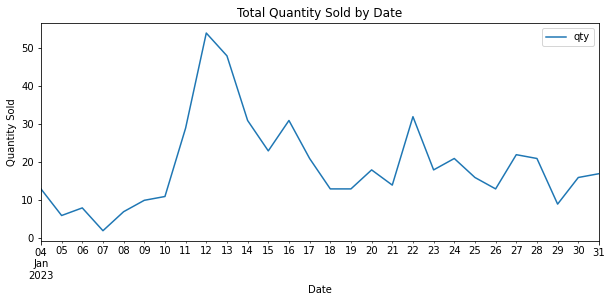

In [92]:
# Group the dataframe by date and sum the qty and stockAvailable columns
grouped_bowl = bowl_df.groupby("createdDate").agg({"qty": "sum"#, "stockAvailable": "sum"
                                                  })
# Create a bar graph of the grouped dataframe
grouped_bowl.plot(kind="line", figsize=(10, 4), rot=0)

# Add labels and titles
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.title("Total Quantity Sold by Date")

# Show the graph
plt.show()



<AxesSubplot:xlabel='createdDate'>

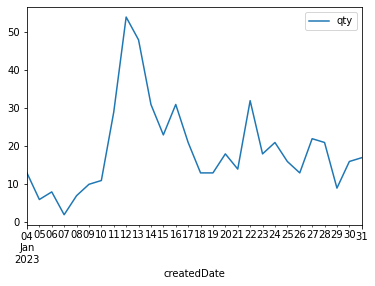

In [93]:
#grouped_bowl = np.log(grouped_bowl) #handling variance with log transformation - transform data back when making 
                                        #predictions

grouped_bowl.plot()

In [94]:
#test and train dataset

grouped_bowl_train = grouped_bowl[:-12]
grouped_bowl_test = grouped_bowl[-12:]

print('Train Data Shape:', grouped_bowl_train.shape)
print('Test Data Shape:', grouped_bowl_test.shape)

grouped_bowl_test.head()

#mask = (grouped_bowl.index < len(grouped_bowl)-5)
#grouped_bowl_train = grouped_bowl[mask].copy()
#grouped_bowl_test = grouped_bowl[~mask].copy()


Train Data Shape: (16, 1)
Test Data Shape: (12, 1)


,qty
createdDate,
2023-01-20,18
2023-01-21,14
2023-01-22,32
2023-01-23,18
2023-01-24,21


In [96]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(grouped_bowl_train)
train_data = scaler.transform(grouped_bowl_train)
test_data = scaler.transform(grouped_bowl_test)


In [98]:
#lR

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(bowl_df[['stockAvailable', 'Sell_through_rate']], bowl_df['qty'], test_size=0.2, random_state=42)

# Create a linear regression object
lr = LinearRegression()

# Fit the model on the training data
lr.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lr.predict(X_test)

# Evaluate the performance of the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 5.51801139746361


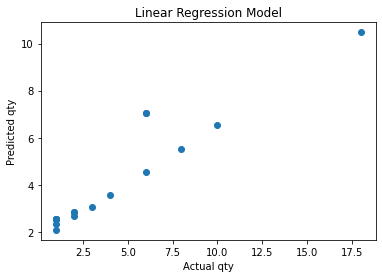

In [99]:
import matplotlib.pyplot as plt

# Create a scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual qty')
plt.ylabel('Predicted qty')
plt.title('Linear Regression Model')
plt.show()

####END

In [69]:
#pip install fugue-jupyter

%%fsql
SELECT summary.Product Title
FROM summary
WHERE summary.Product Title = "Bowl"
PRINT

In [187]:
#summary['Variant'].nunique() #138
#summary['Product Title'].nunique() #17
#summary['createdDate'].unique() #17

In [188]:
# time series

In [189]:
#summary.set_index('createdDate',inplace=True)
summary.head()

,Product Title,Variant,stockAvailable,createdDate,qty,Sell_through_rate
0,Bowl,Crate Bowl I/L Ash,1256.0,2023-01-04,4,0.318471
1,Bowl,Crate Bowl I/L Ash,1256.0,2023-01-05,1,0.079618
2,Bowl,Crate Bowl I/L Ash,1256.0,2023-01-07,2,0.159236
3,Bowl,Crate Bowl I/L Ash,1256.0,2023-01-08,6,0.477707
4,Bowl,Crate Bowl I/L Ash,1256.0,2023-01-09,4,0.318471


Product Title        0
Variant              0
stockAvailable       0
createdDate          0
qty                  0
Sell_through_rate    0
dtype: int64

In [191]:
#https://www.embedded-robotics.com/forecast-sales-using-machine-learning/

In [199]:
#https://www.cienciadedatos.net/documentos/py44-multi-series-forecasting-skforecast.html 
#refer this!

Bowl
83    2.484565
84    3.548668
85    4.311392
86    4.858096
87    5.249961
Name: predicted_mean, dtype: float64


KeyError: 0

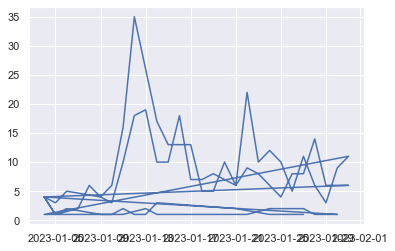

In [195]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Group by product title
grouped = summary.groupby("Product Title")

# Loop through each product and fit ARIMA model
for title, group in grouped:
    # Create ARIMA model with order (1,1,1)
    model = ARIMA(group["qty"], order=(1,1,1))
    
    # Fit model
    model_fit = model.fit()
    
    # Forecast 5 days ahead
    forecast = model_fit.forecast(steps=5)
    
    # Print forecast
    print(title)
    print(forecast)

    
    # Create plot
    if "createdDate" in group.columns:
        plt.plot(group["createdDate"], group["qty"], label="Actual")
        plt.plot(forecast.index, forecast[0], label="Forecast")
        plt.title(title)
        plt.xlabel("Date")
        plt.ylabel("Sales")
        plt.legend()
        plt.show()
    else:
        print(f"No 'createdDate' column in {title} data.")


KeyError: 0

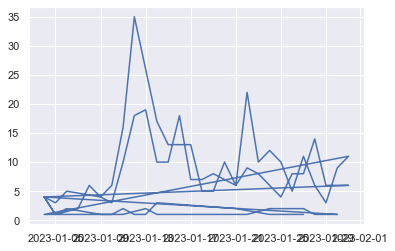

In [198]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load data
#df = pd.read_csv("sales_data.csv")

# Get list of unique product titles
products = summary["Product Title"].unique()

# Loop through each product and fit ARIMA model
for product in products:
    # Get data for current product
    product_data = summary[summary["Product Title"] == product]
    
    # Create ARIMA model with order (1,1,1)
    model = ARIMA(product_data["qty"], order=(1,1,1))
    
    # Fit model
    model_fit = model.fit()
    
    # Forecast 5 days ahead
    forecast = model_fit.forecast(steps=5)
    
    # Create plot
    plt.plot(product_data["createdDate"], product_data["qty"], label="Actual")
    plt.plot(forecast.index, forecast[0], label="Forecast")
    plt.title(product)
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.show()


In [193]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Load data
#df = pd.read_csv("sales_data.csv")

# Group by product title
grouped = summary.groupby("Product Title")

# Loop through each product and fit ARIMA model
for title, group in grouped:
    # Create ARIMA model with order (1,1,1)
    model = ARIMA(group["qty"], order=(1,1,1))
    
    # Fit model
    model_fit = model.fit()
    
    # Forecast 5 days ahead
    forecast = model_fit.forecast(steps=5)
    
    # Print forecast
    print(title)
    print(forecast)


Bowl
83    2.484565
84    3.548668
85    4.311392
86    4.858096
87    5.249961
Name: predicted_mean, dtype: float64
Bowl + Crate Clip
44    9.001879
45    8.592008
46    8.423697
47    8.354581
48    8.326200
Name: predicted_mean, dtype: float64
Bowl Clip
24    17.436148
25    17.818693
26    17.559155
27    17.735238
28    17.615775
Name: predicted_mean, dtype: float64
Collar
110    1.143628
111    1.135632
112    1.136078
113    1.136053
114    1.136054
Name: predicted_mean, dtype: float64
Dispenser
185    1.689249
186    1.732436
187    1.735143
188    1.735312
189    1.735323
Name: predicted_mean, dtype: float64


/Users/revatirameshkharate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/revatirameshkharate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/revatirameshkharate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/revatirameshkharate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index b

Groov
180    16.859774
181    16.473381
182    16.484991
183    16.484642
184    16.484652
Name: predicted_mean, dtype: float64
Harness
71    1.302642
72    1.290717
73    1.290513
74    1.290510
75    1.290510
Name: predicted_mean, dtype: float64
Leash
104    1.308360
105    1.276363
106    1.279684
107    1.279339
108    1.279375
Name: predicted_mean, dtype: float64
Passenger
84    1.474612
85    1.472122
86    1.472110
87    1.472110
88    1.472110
Name: predicted_mean, dtype: float64
Pee Pad
26    3.289041
27    3.345648
28    3.356734
29    3.358905
30    3.359330
Name: predicted_mean, dtype: float64
Pillo
56    1.541671
57    1.500764
58    1.503853
59    1.503620
60    1.503637
Name: predicted_mean, dtype: float64
Poop Bags
62    4.232593
63    4.319584
64    4.321925
65    4.321988
66    4.321990
Name: predicted_mean, dtype: float64
Refurbished Revol
31    1.599569
32    1.703596
33    1.721645
34    1.724777
35    1.725320
Name: predicted_mean, dtype: float64
Revol
632    1.91

/Users/revatirameshkharate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/revatirameshkharate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/revatirameshkharate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/revatirameshkharate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forec

In [36]:
# group the data by Product Title
grouped_df = summary.groupby('Product Title')
grouped_df.info()

AttributeError: 'DataFrameGroupBy' object has no attribute 'info'

In [134]:
# loop through each group to forecast sales using ARIMA


for name, group in grouped_df:
    # create a time series of sales (qty) data
    time_series = pd.Series(group['qty'].values, index=group['createdDate'])
    
    # split the data into train and test sets
    train_data = time_series[:len(time_series)-3]
    test_data = time_series[len(time_series)-3:] 
    
    # fit an ARIMA model on the training data
    from statsmodels.tsa.arima.model import ARIMA
    model = ARIMA(train_data, order=(1,1,0))
    model_fit = model.fit()
    
    # use the model to make predictions on the test data
    forecast = model_fit.forecast(steps=3)
    
    # print the forecasted sales
    print("Product: ", name)
    print("Forecasted sales for next 3 days: ", forecast)
    
    # plot the actual sales and the forecasted sales
    plt.figure(figsize=(12,6))
    plt.plot(train_data, label='Training Data')
    plt.plot(test_data, label='Actual Sales')
    plt.plot(forecast, label='Forecasted Sales')
    plt.title("Sales Forecast for Product: " + name)
    plt.xlabel("Date")
    plt.ylabel("Sales (qty)")
    plt.legend()
    plt.show()

KeyError: 'createdDate'

In [29]:
#pip install fbprophet

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Filter the data by Product Title
#product_titles = summary['Product Title'].unique()
for title in product_titles:
    # Filter the data for a specific product title
    product_data = summary[summary['Product Title'] == title]

    # Create a time series from the data
    ts = pd.Series(product_data['qty'].values, index=product_data['createdDate'])

    # Split the time series into training and testing sets
    train_size = int(len(ts) * 0.8)
    train, test = ts[:train_size], ts[train_size:]

    # Fit the ARIMA model to the training data
    model = ARIMA(train, order=(1, 1, 1))
    model_fit = model.fit()

    # Make predictions on the testing data
    predictions = model_fit.predict(start=len(train), end=len(ts)-1, typ='levels')

    # Plot the actual vs predicted values
    plt.plot(test.index, test.values, label='Actual')
    plt.plot(predictions.index, predictions.values, label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()


KeyError: 'createdDate'

In [ ]:
# Draw Plot
def plot_df(summary, x, y, title="", xlabel='Product Title', ylabel='createdDate', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(summary, x=summary.index, y=summary.value, title='Daily sales')    

In [ ]:
import datetime

train = summary.loc[summary['createdDate'].dt.date < datetime.date(2023, 1, 20)]
valid = summary.loc[(summary['createdDate'].dt.date >= datetime.date(2023, 1, 20)) & (summary['createdDate'].dt.date < datetime.date(2023, 4, 1))]


In [ ]:
#Feature Engineering for Time Series Forecasting

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

models = [RandomForestRegressor(random_state=0, n_estimators=100),
          ExtraTreesRegressor(random_state=0, n_estimators=100)]

In [ ]:
from numba import njit

@njit
def diff(x, lag):
    x2 = np.full_like(x, np.nan)
    for i in range(lag, len(x)):
        x2[i] = x[i] - x[i-lag]
    return x2

In [ ]:
import pandas as pd
from mlforecast import MLForecast

def rolling_mean(x, window):
    return pd.Series(x).rolling(window=window).mean().values

model = MLForecast(models=models,
                   freq='D',
                   lags=[1,7,14],
                   lag_transforms={
                       1: [(rolling_mean, 3), (rolling_mean, 7), (rolling_mean, 28), (diff, 1), (diff, 7)],
                   },
                   date_features=['dayofweek'],
                   num_threads=6)


In [ ]:
model.fit(train, id_col='Product Title', time_col='createdDate', target_col='qty', static_features=[])

p = model.predict(horizon=90, dynamic_dfs=[valid[['Product Title', 'createdDate', 'stockAvailable']]])
p = p.merge(valid[['Product Title', 'createdDate', 'qty']], on=['Product Title', 'createdDate'], how='left')

In [ ]:
import pandas as pd
import numpy as np


%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

In [ ]:
summary.describe()

In [ ]:
#pip install mlforecast

In [ ]:
#spiltting data into train and test

import datetime

# Convert string dates to datetime.date objects
start_date = datetime.datetime.strptime('2017-01-01', '%Y-%m-%d').date()
valid_start_date = datetime.datetime.strptime('2017-01-20', '%Y-%m-%d').date()
valid_end_date = datetime.datetime.strptime('2017-01-30', '%Y-%m-%d').date()

# Filter summary dataframe based on datetime.date objects
train = summary.loc[summary['createdDate'] < start_date]
valid = summary.loc[(summary['createdDate'] >= valid_start_date) & (summary['createdDate'] < valid_end_date)]


In [ ]:
#feature engineering
#Lag
#sliding Window aggregate
#Date Componenets
#Differences

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

models = [RandomForestRegressor(random_state=0, n_estimators=100),
          ExtraTreesRegressor(random_state=0, n_estimators=100)]

from numba import njit

@njit
def diff(x, lag):
    x2 = np.full_like(x, np.nan)
    for i in range(lag, len(x)):
        x2[i] = x[i] - x[i-lag]
    return x2


In [ ]:
from mlforecast import MLForecast
import pandas as pd

summary['createdDate'] = pd.to_datetime(summary['createdDate'].astype('datetime64[ns]'))


models = ...

def rolling_mean(x, w):
    return x.rolling(w).mean()

def diff(x, d):
    return x.diff(d)

model = MLForecast(models=models,
                   freq='D',
                   lags=[1,7,14],
                   lag_transforms={
                       1: [(rolling_mean, 3), (rolling_mean, 7), (rolling_mean, 28), (diff, 1), (diff, 7)],
                   },
                   date_features=['dayofweek'],
                   num_threads=6)

model.fit(train, id_col='Product Title', time_col='createdDate', target_col='qty', static_features=[])

valid = ...

p = model.predict(horizon=90, dynamic_dfs=[valid[['Product Title', 'createdDate']]])
p = p.merge(valid[['Product Title', 'createdDate', 'qty']], on=['Product Title', 'createdDate', 'qty'], how='left')


In [ ]:
#create the object that manages the creation of the features and the training of the models.

from window_ops import rolling_mean
from mlforecast import MLForecast

model = MLForecast(models=models,
                   freq='D',
                   lags=[1,7,14],
                   lag_transforms={
                       1: [(rolling_mean, 3), (rolling_mean, 7), (rolling_mean, 28), (diff, 1), (diff, 7)],
                   },
                   date_features=['dayofweek'],
                   num_threads=6)

model.fit(train, id_col='Product Title', time_col='createdDate', target_col='qty', static_features=[])

p = model.predict(horizon=90, dynamic_dfs=[valid[['Product Title', 'createdDate']]])
p = p.merge(valid[['Product Title', 'createdDate', 'qty']], on=['Product Title', 'createdDate', 'qty'], how='left')



In [ ]:
Salevsinvent_df=pd.concat([summarized_var_df, final_df], axis=1, join = 'outer')
# rename the columns
new_names = {'Product Title': 'Product Title', 'Variant': 'Variant_1', 'stockAvailable': 'Stock_Available',
             'code': 'code', 'Category': 'Category_1', 'Color': 'Color_1', 'Size': 'Size_1', 'Prod_variant': 'Prod_Variant'}
Salevsinvent_df = Salevsinvent_df.rename(columns=new_names)

Salevsinvent_df.sort_values(by = 'Stock_Available', ascending=False).reset_index().head(3)


In [ ]:
#summary = df[['stockAvailable', 'qty']].describe()
summary=Salevsinvent_df.groupby("Product Title").sum()
#summary=Salevsinvent_df.groupby("Product_Title")['qty'].sum()
summary

In [ ]:
final_df=final_df.groupby("Variant")["qty"].sum()
Salevsinvent_df_sum=Salevsinvent_df_sum.sort_values(ascending=False)
Salevsinvent_df_sum

In [ ]:
### Old


###### Available Stock by Product Title

In [ ]:
# group by products sold high level view

summarized_df = pd.DataFrame(stock_data.groupby(['Product Title']).agg({'stockAvailable': 'sum'}).reset_index())

summarized_df = summarized_df.sort_values(by='stockAvailable', ascending=False)

summarized_df.head()

In [ ]:
import matplotlib.pyplot as plt

fig1 = summarized_df.head(10).plot(kind = 'bar', x= 'Product Title' , y ='stockAvailable', title ="# Available Products Stock", figsize=(6, 4), legend=True, fontsize=12)

fig1.set_xlabel("Product", fontsize=12)
fig1.set_ylabel("Quantity", fontsize=12)
plt.xticks(rotation=40)
plt.show()

###### Top 10 product variant which are high in stock

In [ ]:
summarized_var_df = pd.DataFrame(stock_data.groupby(['Product Title', 'Prod_variant']).agg({'stockAvailable': 'sum'}).reset_index())

summarized_var_df = summarized_var_df.sort_values(by='stockAvailable', ascending=False)

summarized_var_df.head(20)


In [ ]:
#import matplotlib.pyplot as plt

fig2 = summarized_var_df.head(10).plot(kind = 'bar', x= 'Prod_variant' , y ='stockAvailable', title ="# Available Product Variant Stock", figsize=(6, 4), legend=True, fontsize=12)

fig2.set_xlabel("Product", fontsize=12)
fig2.set_ylabel("Quantity", fontsize=12)
plt.xticks(rotation=40)
plt.show()


######  10 product variant which are lowest in stock

In [ ]:
# group by products  Bottom 10

summarized_var_df_bottom_10 = pd.DataFrame(stock_data.groupby(['Product Title', 'Prod_variant']).agg({'stockAvailable': 'sum'}).reset_index())

summarized_var_df_bottom_10 = summarized_var_df_bottom_10.sort_values(by='stockAvailable', ascending=True)

summarized_var_df_bottom_10.head(10)

In [ ]:

fig3 = summarized_var_df.tail(5).plot(kind = 'bar', x= 'Prod_variant' , y ='stockAvailable', title ="# Available Products Stock", figsize=(9, 5), legend=True, fontsize=12)

fig3.set_xlabel("Product", fontsize=12)
fig3.set_ylabel("Quantity", fontsize=12)
plt.xticks(rotation=40)
plt.show()


###### Products with no current inventory

In [ ]:
no_stock_avail_df = summarized_var_df[summarized_var_df["stockAvailable"] == 0]
no_stock_avail_df #products which have no inventory